# Michigan Accident Risk Modeling
Build a Random Forest model to predict accident risk levels (Low, Medium, High) for Michigan. The workflow covers resampling, SMOTE, hyperparameter tuning, and threshold tuning focused on risk detection.

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')


## 1. Load Data

In [51]:
# Load data
df = pd.read_csv(r"C:\Users\osiri\Downloads\US_Accidents_March23_sampled_500k.csv")
df = df[df['State'] == 'MI']  # Filter for Michigan

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
df.head()

Dataset shape: (10518, 46)

Column names:
['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
28,A-2826531,Source2,2,2018-05-16 17:45:34,2018-05-16 18:14:43,42.442745,-83.754082,NaN,NaN,0.000,Left lane blocked due to accident on US-23 Nor...,US-23 N,Brighton,Livingston,MI,48116,US,US/Eastern,KOZW,2018-05-16 17:55:00,76.8,NaN,40.0,29.97,10.0,NNW,3.5,NaN,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
78,A-191738,Source2,2,2016-09-02 18:55:39,2016-09-02 19:25:39,42.974300,-83.679016,NaN,NaN,0.000,Accident on Bristol Rd near Greenly St.,Greenly St,Burton,Genesee,MI,48529,US,US/Eastern,KFNT,2016-09-02 18:53:00,69.1,NaN,58.0,30.24,10.0,ENE,11.5,NaN,Scattered Clouds,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
106,A-3015356,Source2,3,2018-02-16 16:16:50,2018-02-16 16:46:14,43.075649,-83.762894,NaN,NaN,0.000,Accident on I-75 Southbound at W Carpenter Rd.,US-23 S,Flint,Genesee,MI,48504,US,US/Eastern,KFNT,2018-02-16 15:53:00,30.0,20.0,54.0,30.21,10.0,WNW,12.7,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
244,A-4425234,Source1,2,2023-01-23 01:53:49.000000000,2023-01-23 04:01:09.000000000,42.332135,-83.085748,42.332055,-83.079628,0.313,EB I-96 Ramp to M-10,I-75,Detroit,Wayne,MI,48216,US,US/Eastern,KDET,2023-01-23 01:53:00,31.0,25.0,85.0,29.16,6.0,NNW,6.0,0.0,Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Night
278,A-2418250,Source2,3,2018-12-28 19:01:12,2018-12-28 19:45:47,42.228817,-83.616928,NaN,NaN,0.000,Right lane blocked due to accident on I-94 Eas...,Huron Rd,Ypsilanti,Washtenaw,MI,48197,US,US/Eastern,KYIP,2018-12-28 18:53:00,37.0,27.7,73.0,29.88,10.0,West,16.1,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night


## 2. Explore Data & Create Target
Inspect the dataset and create the three-level target variable (`Risk_Level`).

In [52]:
df.info()

<class 'pandas.DataFrame'>
Index: 10518 entries, 28 to 499991
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10518 non-null  str    
 1   Source                 10518 non-null  str    
 2   Severity               10518 non-null  int64  
 3   Start_Time             10518 non-null  str    
 4   End_Time               10518 non-null  str    
 5   Start_Lat              10518 non-null  float64
 6   Start_Lng              10518 non-null  float64
 7   End_Lat                4524 non-null   float64
 8   End_Lng                4524 non-null   float64
 9   Distance(mi)           10518 non-null  float64
 10  Description            10518 non-null  str    
 11  Street                 10511 non-null  str    
 12  City                   10518 non-null  str    
 13  County                 10518 non-null  str    
 14  State                  10518 non-null  str    
 15  Zipcode         

In [53]:
df['Severity'].value_counts()

Severity
2    7344
3    2601
4     497
1      76
Name: count, dtype: int64

In [54]:
df['Risk_Level'] = pd.cut(df['Severity'], bins=[0, 1, 2, 4], labels=['Low', 'Medium', 'High'])
df['Risk_Level'].value_counts()   

Risk_Level
Medium    7344
High      3098
Low         76
Name: count, dtype: int64

## 4. Feature Selection & Missing Values
Select modeling features and drop rows with missing values.

In [55]:
missing = df.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])
print(df.shape)

Missing values per column:
 End_Lat                  5994
End_Lng                  5994
Street                      7
Weather_Timestamp          16
Temperature(F)             25
Wind_Chill(F)            2729
Humidity(%)                29
Pressure(in)               24
Visibility(mi)             33
Wind_Direction             50
Wind_Speed(mph)           454
Precipitation(in)        3808
Weather_Condition          26
Sunrise_Sunset             10
Civil_Twilight             10
Nautical_Twilight          10
Astronomical_Twilight      10
dtype: int64
(10518, 47)


In [56]:
df_model = df[["Risk_Level", "City", "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)",
                         "Wind_Direction", "Wind_Speed(mph)", "Precipitation(in)", "Sunrise_Sunset"]]
print(f"Modeling dataset shape: {df_model.shape}")

Modeling dataset shape: (10518, 11)


In [57]:
missing = df_model.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])
df_model = df_model.dropna()
print(f"Modeling dataset shape after dropping missing: {df_model.shape}")
print("Missing values per column after dropping:\n", df_model.isnull().sum())

Missing values per column:
 Temperature(F)         25
Wind_Chill(F)        2729
Humidity(%)            29
Pressure(in)           24
Visibility(mi)         33
Wind_Direction         50
Wind_Speed(mph)       454
Precipitation(in)    3808
Sunrise_Sunset         10
dtype: int64
Modeling dataset shape after dropping missing: (6333, 11)
Missing values per column after dropping:
 Risk_Level           0
City                 0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Sunrise_Sunset       0
dtype: int64


In [36]:
X = df_model.drop(['Risk_Level'], axis=1)
y = df_model['Risk_Level']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:\n{X.columns.tolist()}")

Features shape: (6333, 10)
Target shape: (6333,)

Feature columns:
['City', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Sunrise_Sunset']


## 5. Encode Categoricals & Split
Label-encode categorical features, then split into train/test.

In [58]:
# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object', 'string']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\nEncoded features shape: {X_encoded.shape}")
print(X_encoded.head())

Categorical columns to encode: ['City', 'Wind_Direction', 'Sunrise_Sunset']

Encoded features shape: (6333, 10)
     City  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  \
244    76            31.0           25.0         85.0         29.16   
282   113            58.0           58.0         90.0         28.67   
552    93            91.0           91.0         47.0         29.07   
568    96            81.0           81.0         69.0         29.31   
887   161            68.0           68.0         84.0         28.95   

     Visibility(mi)  Wind_Direction  Wind_Speed(mph)  Precipitation(in)  \
244             6.0               8              6.0                0.0   
282            10.0              13              8.0                0.0   
552            10.0              19             10.0                0.0   
568            10.0               7              5.0                0.0   
887            10.0               3             13.0                0.0   

     Sunri

In [59]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set distribution:")
print(y_train.value_counts())

Training set size: 5066
Test set size: 1267

Training set distribution:
Risk_Level
Medium    3866
High      1139
Low         61
Name: count, dtype: int64


## 6. Resample Training Set
First undersample Medium by half, then apply SMOTE to oversample Low class. This is done only on training data to avoid leakage.

In [60]:
# Step 1: Undersample Medium class in training set
train_df = pd.concat([X_train, y_train], axis=1)

medium_train = train_df[train_df['Risk_Level'] == 'Medium']
high_train = train_df[train_df['Risk_Level'] == 'High']
low_train = train_df[train_df['Risk_Level'] == 'Low']

# Undersample Medium by half
medium_train_undersampled = resample(medium_train, n_samples=len(medium_train)//2, random_state=42)

# Combine after undersampling
train_balanced = pd.concat([high_train, medium_train_undersampled, low_train])

# Separate features and target
X_train_balanced = train_balanced.drop('Risk_Level', axis=1)
y_train_balanced = train_balanced['Risk_Level']

print("After undersampling Medium in training set:")
print(y_train_balanced.value_counts())

# Step 2: Apply SMOTE to oversample Low class
smote = SMOTE(sampling_strategy={
    'Low': 1000,  # Target ~1,000 Low samples
}, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_balanced, y_train_balanced)

print("\nAfter SMOTE on training data:")
print(y_train_smote.value_counts())
print(f"\nFinal training set size: {X_train_smote.shape[0]}")

After undersampling Medium in training set:
Risk_Level
Medium    1933
High      1139
Low         61
Name: count, dtype: int64

After SMOTE on training data:
Risk_Level
Medium    1933
High      1139
Low       1000
Name: count, dtype: int64

Final training set size: 4072


## 7. Hyperparameter Tuning
Grid search to find the best Random Forest settings using F1-weighted.

In [61]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

grid_search = GridSearchCV(rf_grid, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)

print("Starting GridSearchCV... (this may take a few minutes)")
grid_search.fit(X_train_smote, y_train_smote)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV... (this may take a few minutes)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation F1-Score: 0.7343


## 8. Train Optimized Model & Evaluate

In [62]:
# Train optimized Random Forest with best parameters
rf_model = grid_search.best_estimator_

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

# Evaluate
print("Optimized Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, rf_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

Optimized Random Forest Results:
Accuracy: 0.6338
F1-Score (weighted): 0.6605

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.47      0.40       285
         Low       0.05      0.20      0.07        15
      Medium       0.81      0.69      0.75       967

    accuracy                           0.63      1267
   macro avg       0.40      0.45      0.41      1267
weighted avg       0.70      0.63      0.66      1267



## 9. Confusion Matrix

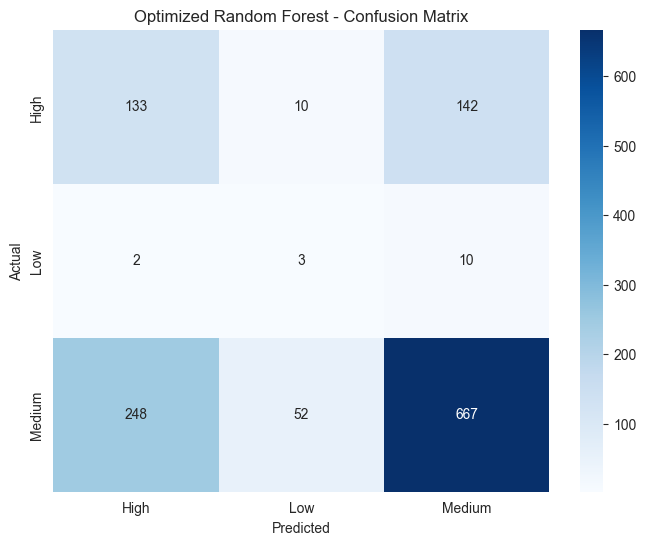

In [63]:
# Confusion Matrix for Optimized Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Optimized Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 11. Feature Importance

Top 10 Most Important Features:
             Feature  Importance
2      Wind_Chill(F)    0.167578
1     Temperature(F)    0.167012
3        Humidity(%)    0.135006
0               City    0.130239
4       Pressure(in)    0.125394
7    Wind_Speed(mph)    0.101941
6     Wind_Direction    0.074712
9     Sunrise_Sunset    0.043266
5     Visibility(mi)    0.042864
8  Precipitation(in)    0.011987


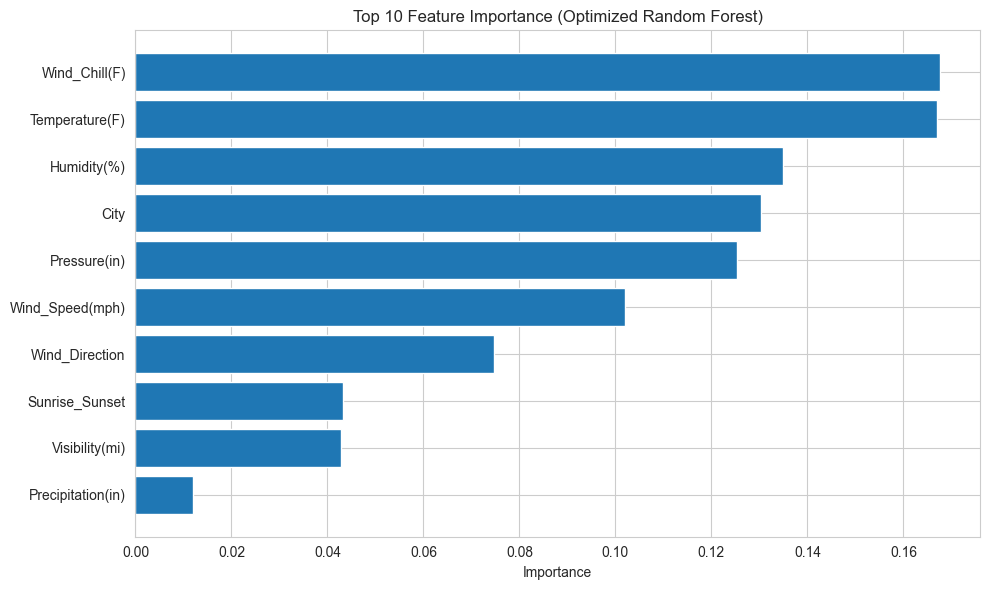

In [47]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Optimized Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path
import json
import joblib

# Create output folder
artifacts_dir = Path("model_artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save the trained model
model_path = artifacts_dir / "rf_model.joblib"
joblib.dump(rf_model, model_path)

# Save threshold and label info for consistent inference
metadata = {
    "best_threshold": float(best_threshold),
    "class_labels": list(class_labels),
    "categorical_cols": list(categorical_cols)
}
metadata_path = artifacts_dir / "model_metadata.json"
metadata_path.write_text(json.dumps(metadata, indent=2))

print(f"Saved model to: {model_path.resolve()}")
print(f"Saved metadata to: {metadata_path.resolve()}")


## Export Model Artifacts
Save the optimized model and tuned threshold so you can load and use them later.